# LES Band Data Analysis
---
### Carter J. Humphreys
Email: [chumphre@oswego.edu](mailto:chumphre@oswego.edu) | GitHub:[@HumphreysCarter](https://github.com/HumphreysCarter) | Website: [carterhumphreys.com](http://carterhumphreys.com/)

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

from metpy.plots import USCOUNTIES
from datetime import datetime
from scipy.stats import gaussian_kde

In [17]:
dataDIR='../data/BAND_POSITION'

In [18]:
def find_nthIndex(fullString, find, n):
    start = fullString.find(find)
    while start >= 0 and n > 1:
        start = fullString.find(find, start+len(find))
        n -= 1
    return start

In [19]:
data=[]
eventCount=0
for eventID in range(1, 37):
    eventDIR=f'{dataDIR}/Ontario_LES_Event{str(eventID).zfill(2)}'

    for dataFile in os.listdir(eventDIR):
        eventCount+=1

        posData = pd.read_csv(f'{eventDIR}/{dataFile}')

        radarSite=dataFile[(find_nthIndex(dataFile, '_', 1)+1):find_nthIndex(dataFile, '_', 2)]
        dateTime=dataFile[(find_nthIndex(dataFile, '_', 2)+1):find_nthIndex(dataFile, '.csv', 1)]
        dateTime=datetime.strptime(dateTime, '%Y%m%d_%H%M%S')

        for index, row in posData.iterrows():
            #posData.insert(0, 0, dateTime)
            #posData.insert(0, 1, radarSite)

            #posData=posData.values[i]

            data.append(row)

df = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Azimuth [deg]', 'Range [km]', 'Data Value [dBZ]'])
df

,Latitude,Longitude,Azimuth [deg],Range [km],Data Value [dBZ]
0,43.552910,-76.205612,242.1,47.91,26.5
1,43.540024,-76.184608,239.6,47.14,24.5
2,43.527122,-76.166595,237.1,46.67,4.0
3,43.512066,-76.145592,234.3,46.23,13.5
4,43.496994,-76.127586,231.5,46.09,10.0
...,...,...,...,...,...
19,43.118633,-75.378830,160.8,75.20,19.0
20,43.075756,-75.305275,158.1,81.42,8.0
21,43.039627,-75.247131,156.1,86.94,20.5
22,42.994476,-75.186058,154.4,94.00,18.0


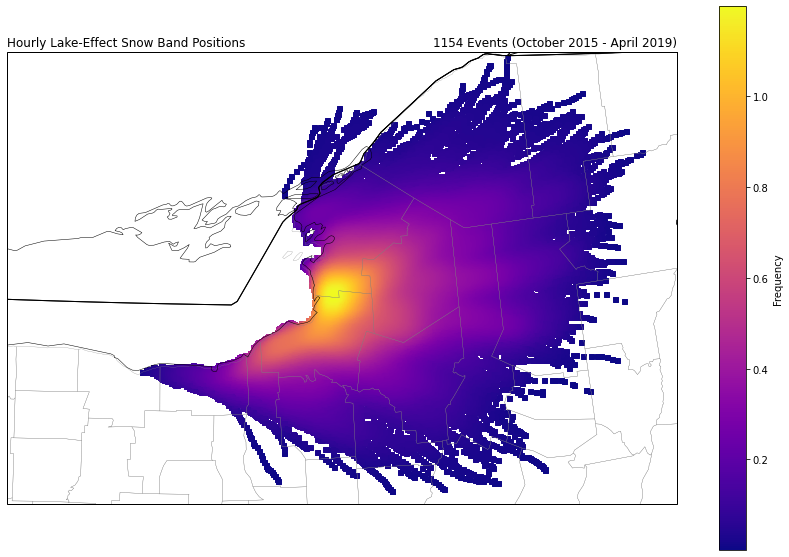

In [20]:
# Plot extent
plotExtent = [-78.5, -73.5, 42.5, 45]

# Create the figure and an axes set to the projection
proj = ccrs.Stereographic(central_longitude=((plotExtent[1]-plotExtent[0])/2+plotExtent[0]), central_latitude=((plotExtent[3]-plotExtent[2])/2+plotExtent[2]))
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(plotExtent)

# Add geographic features
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='gray', linewidth=0.25)
state_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)
country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1.0)

# Get point data
lat = df['Latitude'].values
lon = df['Longitude'].values
dbz = df['Data Value [dBZ]'].values

# Calculate the point density
xy = np.vstack([lon, lat])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]
scatter=ax.scatter(lon, lat, c=z, cmap='plasma', transform=ccrs.PlateCarree(), marker='s', s=25)
cbar=plt.colorbar(scatter)
cbar.ax.set_ylabel('Frequency')

# Set a title and show the plot
ax.set_title('Hourly Lake-Effect Snow Band Positions', loc='Left')
ax.set_title(f'{eventCount} Events (October 2015 - April 2019)', loc='Right')

# Export fig
plt.show()